In [1]:
from integrators import RK4, RK4_timestepper, FE_timestepper
from tools import ScalarTool, VectorTool, create_grid, dt_cfl
from operators import OperatorKit
import numpy as np
from copy import copy
from post_processing import plot_norms, compute_norms
import pickle
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt


def import_run(folder_path,Pe):
    pkl_file_path = folder_path + 'output-pe=%d' % Pe +'/pe=%d' % Pe + '.pkl'
    print('Pickle file path: '+pkl_file_path)
    pkl_file = open(pkl_file_path, 'rb')
    [time,th]=pickle.load(pkl_file)
    return [time,th]


def get_line_styling(n):
    style_list = ['-','--',':','-.'] 
    width_list = [1.0,2.0,3.0]
    

    style_width_pair_list = []
    for width in width_list:
        for style in style_list:
            style_width_pair = [style,width]
            style_width_pair_list.append(style_width_pair)

    return style_width_pair_list[n % len(style_width_pair_list)]

def deriv(t,f):
    
    dfdt = np.zeros(np.shape(f))
    for i in range(1,len(t)-1):
        dfdt[i]= (f[i+1] - f[i-1])/(t[i+1]-t[i-1])
    dfdt[0]= (f[1] - f[0])/(t[1]-t[0])   
    dfdt[-1]= (f[-1] - f[-2])/(t[-1]-t[-2])   
    return dfdt


manuscript_image_folder = 'nonlinearity/images/'
constraint = 'enstrophy' # ... 'energy' or 'enstrophy'
    

In [2]:
# Pe infinity case
L=1.0

if constraint == 'energy':
    folder_path ='/Volumes/Transcend/pde_energy_inf/output-pe=inf/'
elif constraint == 'enstrophy':
    folder_path ='/Volumes/Transcend/pde_enstrophy_inf/output-pe=inf/'

pkl_file_path = folder_path + 'pe=inf.pkl'
print('Pickle file path: '+pkl_file_path)
pkl_file = open(pkl_file_path, 'rb')
[time_inf,th_inf]=pickle.load(pkl_file)

(tsteps,N,_) = np.shape(th_inf)
print('Done loading pickle file.')
[hm1_inf,l2_inf,h1_inf]= compute_norms(th_inf,N,L)
ind_inf = np.abs(l2_inf - 10.0**(-12)).argmin()
print('(Truncating data when L2 is near 10^-12) Truncation time: ',time_inf[ind_inf])
#     plot_norms(time[:ind],th[:ind],N,L , graph='log')
#     plt.show()




Pickle file path: /Volumes/Transcend/pde_enstrophy_inf/output-pe=inf/pe=inf.pkl
Done loading pickle file.
(Truncating data when L2 is near 10^-12) Truncation time:  1.29648241206


In [3]:
Pe_list = [  16.0 ,22.6274170, 32.0, 45.2548340 ,64.0, 90.5096680, 128.0, 181.019336 ,256.0 ,362.038672, 512.0, 724.077344, 1024.0, 1448.15469, 2048.0, 2896.30938 ,4096.0 ] 
L=1.0

if constraint == 'energy':
    folder_path ='/Volumes/Transcend/pde2/'
elif constraint == 'enstrophy':
    folder_path ='/Volumes/Transcend/pde4/'
    
    
ind_list = []
time_list = []
th_list = []
hm1_list=[]
l2_list=[]
h1_list=[]
N_list = []
tsteps_list = []


for Pe in Pe_list:
    print('%d'% Pe)
    [time,th] = import_run(folder_path,Pe)
    (tsteps,N,_) = np.shape(th)
    print('Done loading pickle file.')
    [hm1,l2,h1]= compute_norms(th,N,L)
    ind = np.abs(l2 - 10.0**(-12)).argmin()
    print('(Truncating data when L2 is near 10^-12) Truncation time: ',time[ind])
    #     plot_norms(time[:ind],th[:ind],N,L , graph='log')
    #     plt.show()
    
    #store info
    time_list.append(time)
    th_list.append(th)
    ind_list.append(ind)
    hm1_list.append(hm1)
    l2_list.append(l2)
    h1_list.append(h1)
    N_list.append(N)
    tsteps_list.append(tsteps)

16
Pickle file path: /Volumes/Transcend/pde4/output-pe=16/pe=16.pkl
Done loading pickle file.
(Truncating data when L2 is near 10^-12) Truncation time:  2.0
22
Pickle file path: /Volumes/Transcend/pde4/output-pe=22/pe=22.pkl
Done loading pickle file.
(Truncating data when L2 is near 10^-12) Truncation time:  2.0
32
Pickle file path: /Volumes/Transcend/pde4/output-pe=32/pe=32.pkl
Done loading pickle file.
(Truncating data when L2 is near 10^-12) Truncation time:  2.0
45
Pickle file path: /Volumes/Transcend/pde4/output-pe=45/pe=45.pkl
Done loading pickle file.
(Truncating data when L2 is near 10^-12) Truncation time:  2.0
64
Pickle file path: /Volumes/Transcend/pde4/output-pe=64/pe=64.pkl
Done loading pickle file.
(Truncating data when L2 is near 10^-12) Truncation time:  2.0
90
Pickle file path: /Volumes/Transcend/pde4/output-pe=90/pe=90.pkl
Done loading pickle file.
(Truncating data when L2 is near 10^-12) Truncation time:  2.0
128
Pickle file path: /Volumes/Transcend/pde4/output-pe=12

In [4]:
if constraint == 'enstrophy': 
    final_ind = len(Pe_list)
elif constraint == 'energy': 
    final_ind = len(Pe_list)-6


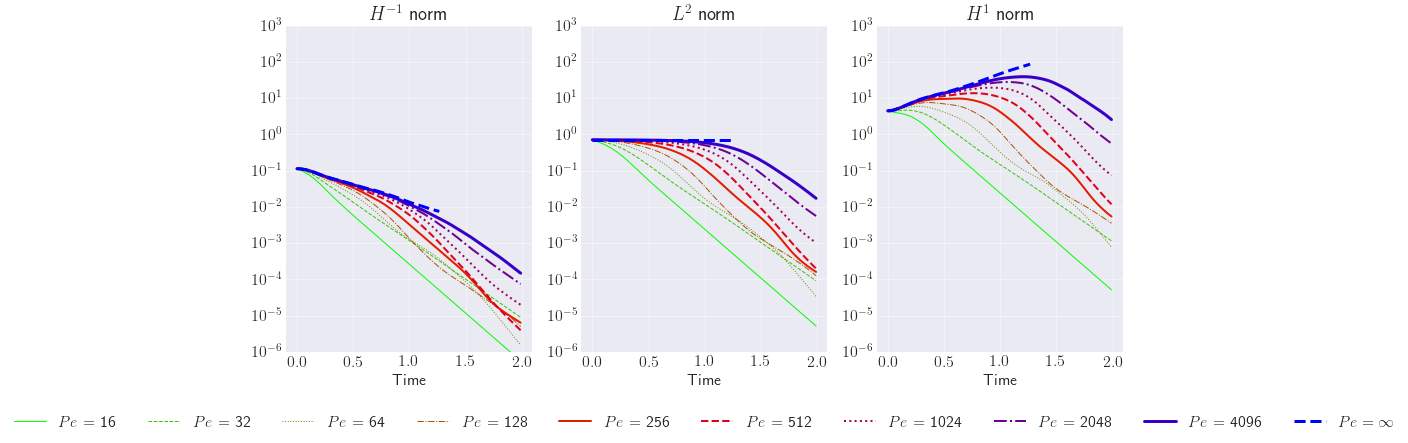

In [13]:
plt.figure(figsize = (9,6))
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=16)

pltnum = 0

with plt.style.context(('seaborn-darkgrid')):
    f, axes = plt.subplots(1,3,figsize=(15,6))



    for i in [0,1,2]:

        pltnum = 0
        color=iter(plt.cm.brg_r(np.linspace(0,2,final_ind + 2)))
        for j in range(0,final_ind,2):
            time = time_list[j][:ind_list[j]]

            if i ==0:
                norm = hm1_list[j][:ind_list[j]] 
            elif i == 1:
                norm = l2_list[j][:ind_list[j]] 
            elif i == 2:
                norm = h1_list[j][:ind_list[j]] 

            [style, width]=get_line_styling(pltnum)
            c = next(color)
            axes[i].semilogy(time, norm,
                         label = '$Pe$ = %d'% Pe_list[j],
                         linewidth = width,
                         linestyle = style,
                         color = c)

            pltnum += 1 

        # ADD PE = \INFTY
        [style, width]=get_line_styling(pltnum)
        c = next(color)
        if i == 0:
            axes[i].semilogy(time_inf[:ind_inf], hm1_inf[:ind_inf],
                     label = '$Pe = \infty$',
                     linewidth = width,
                     linestyle = style,
                     color = c)
        elif i == 1:
            axes[i].semilogy(time_inf[:ind_inf], l2_inf[:ind_inf],
                 label = '$Pe = \infty$',
                 linewidth = width,
                 linestyle = style,
                 color = c)
        elif i == 2:
            axes[i].semilogy(time_inf[:ind_inf], h1_inf[:ind_inf],
             label = '$Pe = \infty$',
             linewidth = width,
             linestyle = style,
             color = c)

        axes[i].set_xlabel('Time')
        axes[i].grid(alpha=0.5)
        if constraint == 'energy':
            axes[i].set_ylim([10.**(-14),10.**(3)])
        elif constraint == 'enstrophy':
            axes[i].set_ylim([10.**(-6),10.**(3)])


    axes[1].legend(loc='upper center', bbox_to_anchor=(0.5,-0.15), ncol = len(Pe_list)-6)


    axes[0].set_title('$H^{-1}$ norm')
    axes[1].set_title('$L^{2}$ norm')
    axes[2].set_title('$H^{1}$ norm')

    #f.subplots_adjust(wspace = 0.05, bottom=0.0, left=0.0, top = 1.0, right=1.0)
    #f.subplots_adjust(wspace = 0.15)
    plt.savefig(manuscript_image_folder+constraint+'_norms.eps',dpi = 300, format = 'eps',bbox_inches='tight')
    plt.show()

Pe = $\infty$
Pe =  256.0


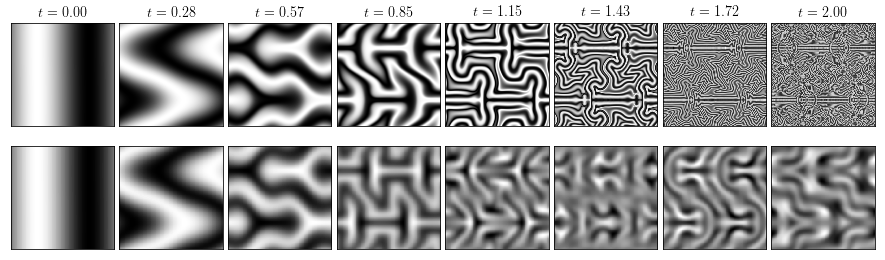

In [6]:

#final_time = time_list[pe_ind][ind_list[pe_ind]]
if constraint == 'energy':
    pe_ind = 2
    final_time = (time_inf[ind_inf])*8./4.
else:
    pe_ind = 8
    #final_time = (time_inf[ind_inf])
    final_time = 2.0
num_frames = 8

print('Pe = $\infty$')
print('Pe = ',Pe_list[pe_ind ])
th_hist = th_list[pe_ind]
time = time_list[pe_ind]
times2plot = np.linspace(time[0],final_time,num_frames)
indicies2plot_u= [ np.abs(time_inf - times2plot[i]).argmin() for i in range(len(times2plot))] 
indicies2plot_l= [ np.abs(time - times2plot[i]).argmin() for i in range(len(times2plot))] 
#ind = np.abs(l2 - 10.0**(-12)).argmin()
#(tsteps,N,_) = np.shape(th_hist)
#st= ScalarTool(N,L)

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=12)

fig_width = 12
fig_height = 2.1*fig_width/num_frames

f, (axes_u,axes_l) = plt.subplots(2,len(indicies2plot_l),sharey = True,figsize=(fig_width,fig_height))
if constraint == 'energy':
    end_ind_u=ind_inf
else:
    end_ind_u=indicies2plot_u[-1]
    
for i,index in enumerate(indicies2plot_u):
    if index <= end_ind_u:
        im = axes_u[i].imshow(np.transpose(th_inf[index]),
                        cmap=plt.cm.gray,
                        extent=(0, L, 0, L),
                        origin="lower")
    else:
        axes_u[i].get_xaxis().set_visible(False)
        axes_u[i].get_yaxis().set_visible(False)
        axes_u[i].axis('off')
        
    axes_u[i].set_xticks([])
    axes_u[i].set_yticks([])
    
    

    
    
for i,index in enumerate(indicies2plot_l):
    im = axes_l[i].imshow(np.transpose(th_list[pe_ind ][index]),
                    cmap=plt.cm.gray,
                    extent=(0, L, 0, L),
                    origin="lower")
    axes_l[i].set_xticks([])
    axes_l[i].set_yticks([])
    #axes_l[i].set_title('$t = %.2f $' % time[index])
    axes_u[i].set_title('$t = %.2f $' % time[index])

f.subplots_adjust(wspace = 0.05, bottom=0.0, left=0.0, top = 1.0, right=1.0)
plt.savefig(manuscript_image_folder+ constraint+'_film.eps',dpi = 300, format = 'eps',bbox_inches='tight')


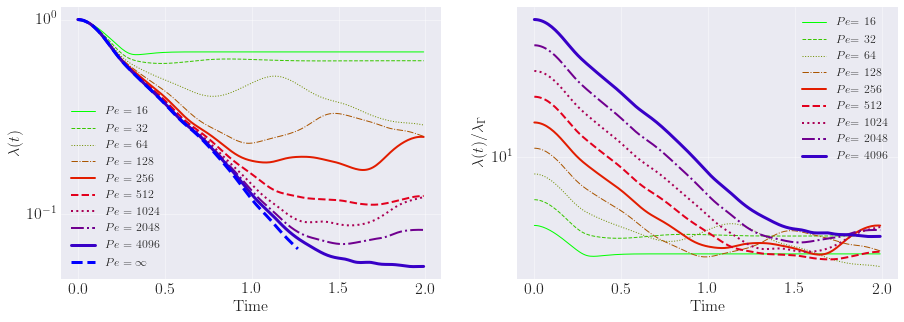

In [14]:
with plt.style.context(('seaborn-darkgrid')):

    fig, axes = plt.subplots(1,2,figsize = (15,5))
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif', size=12)


    pltnum = 0
    color=iter(plt.cm.brg_r(np.linspace(0,2,final_ind + 2)))

    for i in range(0,final_ind,2):
        time = time_list[i][:ind_list[i]]
        hm1 = hm1_list[i][:ind_list[i]]
        l2 = l2_list[i][:ind_list[i]]
        length = 2*np.pi*hm1/l2
        [style, width]=get_line_styling(pltnum)
        c = next(color)
        pltnum +=1
        axes[0].semilogy(time, length,
                     label = '$Pe$ = %d'% Pe_list[i],
                     linewidth = width,
                     linestyle = style,
                     color = c)
        axes[0].grid(alpha=0.5)
        axes[0].set_xlabel('Time')
        axes[0].set_ylabel('$\lambda (t)$')
        axes[0].legend()

    # Pe infinity
    length_inf = 2*np.pi*hm1_inf/l2_inf
    [style, width]=get_line_styling(pltnum)
    pltnum +=1
    c = next(color)
    axes[0].semilogy(time_inf[:ind_inf], length_inf[:ind_inf],
             label = '$Pe = \infty$',
             linewidth = width,
             linestyle = style,
             color = c)
    axes[0].grid(alpha=0.5)
    axes[0].set_xlabel('Time')
    axes[0].set_ylabel('$\lambda (t)$')
    axes[0].legend()

    pltnum = 0
    color=iter(plt.cm.brg_r(np.linspace(0,2,final_ind + 2)))

    for i in range(0,final_ind,2):
        time = time_list[i][:ind_list[i]]
        hm1 = hm1_list[i][:ind_list[i]]
        l2 = l2_list[i][:ind_list[i]]
        length = 2*np.pi*hm1/l2
        [style, width]=get_line_styling(pltnum)
        c = next(color)
        if constraint == 'energy':
            length_scaled = length*Pe_list[i]
        elif constraint == 'enstrophy':
            length_scaled = length*Pe_list[i]**0.5
        axes[1].semilogy(time, length_scaled,
                     label = '$Pe$= %d'% Pe_list[i],
                     linewidth = width,
                     linestyle = style,
                     color = c)
        axes[1].grid(alpha=0.5)
        axes[1].set_xlabel('Time')
        if constraint == 'energy':
            axes[1].set_ylabel('$\lambda (t) / \lambda_{U}$')
        elif constraint == 'enstrophy':
            axes[1].set_ylabel('$\lambda (t) / \lambda_{\Gamma}$')
        axes[1].legend()
        pltnum +=1





    plt.savefig(manuscript_image_folder+constraint+'_length.eps',dpi = 300, format = 'eps',bbox_inches='tight')


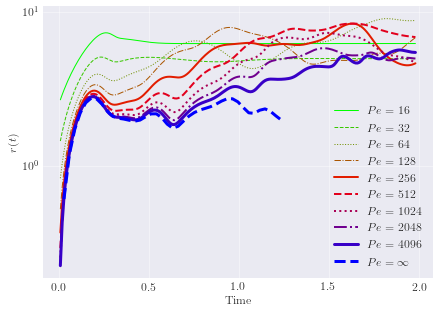

In [15]:
with plt.style.context(('seaborn-darkgrid')):

    if constraint =='enstrophy':

        plt.figure(figsize = (7,5))
        plt.rc('text', usetex=True)
        plt.rc('font', family='serif', size=12)

        pltnum = 0
        color=iter(plt.cm.brg_r(np.linspace(0,2,final_ind + 2)))

        for i in range(0,final_ind,2):
            time = time_list[i][:ind_list[i]]
            hm1 = hm1_list[i][:ind_list[i]]
            l2 = l2_list[i][:ind_list[i]]
            exprate = deriv(time,hm1)/hm1
            [style, width]=get_line_styling(pltnum)
            c = next(color)
            pltnum +=1
            rate = -exprate[1:-1]
            plt.semilogy(time[1:-1], 
                         rate,
                         label = '$Pe$ = %d'% Pe_list[i],
                         linewidth = width,
                         linestyle = style,
                         color = c)
            plt.grid(alpha=0.5)
            plt.xlabel('Time')
            plt.ylabel('$r(t)$')
            plt.legend()

        time = time_inf[:ind_inf]
        exprate = deriv(time_inf[:ind_inf],hm1_inf[:ind_inf])/hm1_inf[:ind_inf]
        [style, width]=get_line_styling(pltnum)
        c = next(color)
        pltnum +=1
        rate = -exprate[1:-1]
        plt.semilogy(time[1:-1], 
                     rate,
                     label = '$Pe =\infty$ ' ,
                     linewidth = width,
                     linestyle = style,
                     color = c)
        plt.grid(alpha=0.5)
        plt.xlabel('Time')
        plt.ylabel('$r(t)$')
        plt.legend()



    if constraint =='energy':
        fig, axes = plt.subplots(1,2,figsize = (12,5))
        plt.rc('text', usetex=True)
        plt.rc('font', family='serif', size=12)

        pltnum = 0
        color=iter(plt.cm.brg_r(np.linspace(0,2,final_ind + 2)))

        for i in range(0,final_ind,2):
            time = time_list[i][:ind_list[i]]
            hm1 = hm1_list[i][:ind_list[i]]
            l2 = l2_list[i][:ind_list[i]]
            #exprate = deriv(time,l2)/l2
            exprate = deriv(time,hm1)/hm1
            [style, width]=get_line_styling(pltnum)
            c = next(color)
            pltnum +=1
            rate = -exprate[1:-1]
            axes[0].semilogy(time[1:-1], -exprate[1:-1],
                         label = '$Pe$ = %d'% Pe_list[i],
                         linewidth = width,
                         linestyle = style,
                         color = c)
            axes[0].grid(alpha=0.5)
            axes[0].set_xlabel('Time')
            axes[0].set_ylabel('$r(t)$')
            axes[0].legend()

        time = time_inf[:ind_inf]
        exprate = deriv(time_inf[:ind_inf],hm1_inf[:ind_inf])/hm1_inf[:ind_inf]
        [style, width]=get_line_styling(pltnum)
        c = next(color)
        pltnum +=1
        rate = -exprate[1:-1]
        axes[0].semilogy(time[1:-1], -exprate[1:-1],
                     label = '$Pe =\infty$ ',
                     linewidth = width,
                     linestyle = style,
                     color = c)
        axes[0].grid(alpha=0.5)
        axes[0].set_xlabel('Time')
        axes[0].set_ylabel('$r(t)$')
        axes[0].legend()

        pltnum = 0
        color=iter(plt.cm.brg_r(np.linspace(0,2,final_ind + 2)))

        for i in range(0,final_ind,2):
            time = time_list[i][:ind_list[i]]
            hm1 = hm1_list[i][:ind_list[i]]
            l2 = l2_list[i][:ind_list[i]]
            exprate = deriv(time,hm1)/hm1
            [style, width]=get_line_styling(pltnum)
            c = next(color)
            pltnum +=1
            axes[1].semilogy(time[1:-1], -exprate[1:-1]/Pe_list[i],
                         label = '$Pe$ = %d'% Pe_list[i],
                         linewidth = width,
                         linestyle = style,
                         color = c)
            axes[1].grid(alpha=0.5)
            axes[1].set_xlabel('Time')
            axes[1].set_ylabel('$r(t)/r_{U}$')
            axes[1].legend()



    plt.savefig(manuscript_image_folder+constraint+'_rate.eps',dpi = 300, format = 'eps',bbox_inches='tight')


In [11]:
print(plt.style.available)

['_classic_test', 'bmh', 'classic', 'dark_background', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark-palette', 'seaborn-dark', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'seaborn']
